## Introduction

> This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

> Our analysis will try to answer questions of how duration between booking and reservation and other factors affect reservation price. Further questions of price analysis will also be performed to find optimum independent parameters to find minimum dependent variable value, in this case, the booking price.

important commands
> - Shift + Enter (executes cell)
> - Alt + Enter (executes and creates new cell)
> - Esc + Shift + Up/Down (expands selection)
> - Up/Down (moves cells up/down)

> Esc + M (converts cell to markup)
> Esc + Y (converts cell to code)
> Esc + H (shows all commands)

> Underscore twice (converts to bold)
> Astrisk once (convrets to italics)


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
import seaborn as sns

## Exploratory Analysis

Read csv files without header included and show shape

In [2]:
df_hotel =pd.read_csv("hotel_bookings.csv", skiprows=0, header=0)
# storing data in backup for easy loading in next cell 
# (helps keep run context for each cell, so that they can be run independently)
df_hotel.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
weekday = []
isWeekend = []
for index, row in df_hotel.iterrows():
    year = df_hotel['arrival_date_year'].iloc[index]
    month_name = df_hotel['arrival_date_month'].iloc[index]
    month_number = datetime.datetime.strptime(month_name, '%B').month
    dayOfMonth = df_hotel['arrival_date_day_of_month'].iloc[index]
    dayOfWeek = datetime.datetime(year,month_number,dayOfMonth).weekday()
    weekday.append(dayOfWeek)
    if (dayOfWeek>3):
        isWeekend.append(1)
    else:
        isWeekend.append(0)
       
df_hotel['arrival_weekday_num'] = weekday
df_hotel['arrival_day_is_weekend'] = isWeekend

df_hotel.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_weekday_num,arrival_day_is_weekend
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,0


In [4]:
# sample read and save - will be removed after project is done
#df_hotel = pd.read_pickle('hotel_bookings_.pkl')
df_hotel.to_pickle('hotel_bookings_1.pkl')
print(df_hotel.shape)
df_hotel.to_pickle('hotel_bookings_.pkl')

(119390, 34)


<hr><hr>

Show columns and their data types for further analysis

In [5]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

<hr><hr>
Describe distributions of each column, it will make sense for numerical columns

In [6]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')
df_hotel.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_weekday_num,arrival_day_is_weekend
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2.995929,0.434098
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,1.951750,0.495640
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,3.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,5.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,6.000000,1.000000


The above data types show that largenumber of columns such as hotel, arrival_date_month, children, meal, country etc. must be converted to make sense of the data for regression analysis.
<hr>

List sum of __NA__ values to consider replacement

In [7]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')
print(df_hotel.isna().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Rows with empty __Country__ can be dropped since it is a very small number of rows

In [8]:
df_hotel = pd.read_pickle('hotel_bookings_1.pkl')

df_hotel=df_hotel.dropna(subset=["country"]) 

df_hotel.to_pickle('hotel_bookings_2.pkl')
df_hotel.shape

(118902, 34)

Distribution of countries by number of rows is where country contirbutes more than 100 rows:

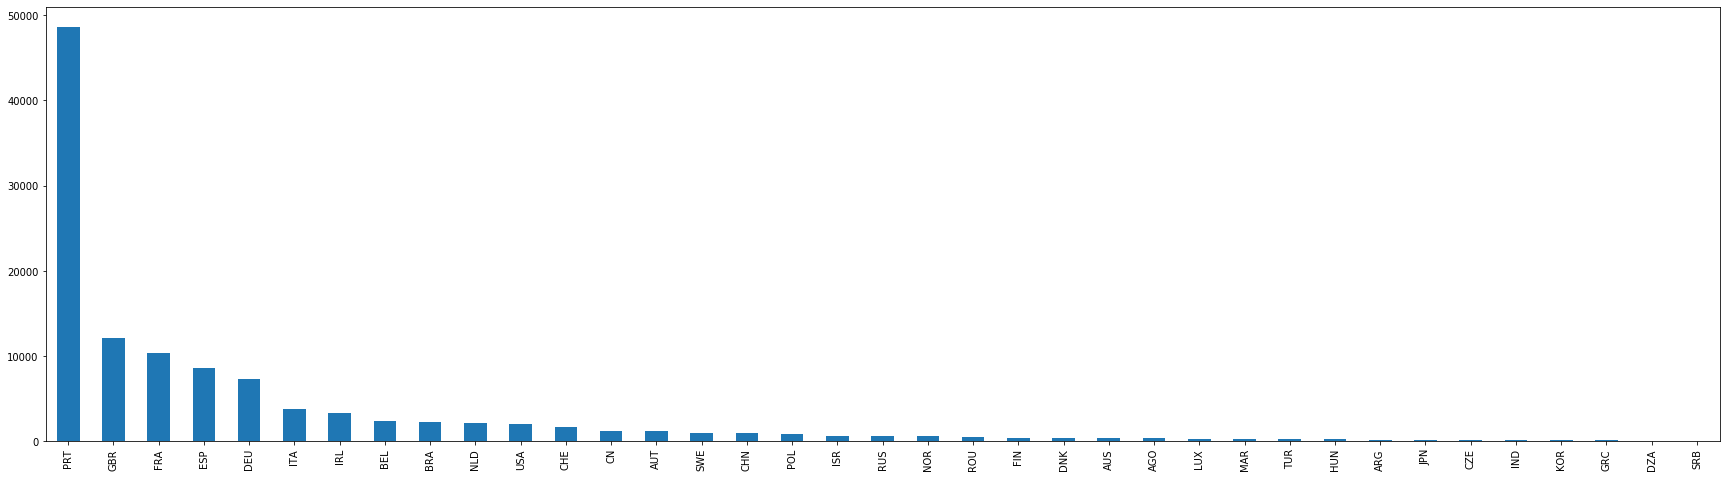

In [9]:
df_hotel = pd.read_pickle('hotel_bookings_2.pkl')
country_vc = df_hotel.country.value_counts()
country_vc[country_vc > 100].plot(kind="bar",figsize=(30, 8))

This indicates that countries that contribute less than 100 rows, contribute very little number of rows to the data compared to countries with most contribution of rows.
Therefore, it is a good idea to reduce number of countries to those with more than 100 rows, since that will give us a smaller number of countries for hot encoding.
Based on above logic, we will remove data from countries that __contirbute < 100 rows__

In [10]:
df_hotel = pd.read_pickle('hotel_bookings_2.pkl')

df_hotel = df_hotel.groupby('country').filter(lambda x: len(x) > 100)

df_hotel.to_pickle('hotel_bookings_3.pkl')

print(df_hotel.shape)
print('\nUnique countries without rows < 100: \n', df_hotel.country.unique())

(116412, 34)

Unique countries without rows < 100: 
 ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'ARG' 'POL' 'DEU' 'BEL'
 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'CZE' 'BRA' 'FIN'
 'LUX' 'IND' 'CHN' 'MAR' 'SRB' 'AUT' 'TUR' 'AGO' 'ISR' 'DZA' 'KOR' 'HUN'
 'JPN']


<hr>


__Children__ are empty in only 4 rows. Replacing them with median number of children can be used to populated those 4 rows.

In [11]:
df_hotel = pd.read_pickle('hotel_bookings_3.pkl')

df_hotel['children'].fillna(df_hotel['children'].median(),inplace=True)

df_hotel.to_pickle('hotel_bookings_4.pkl')

<hr><hr>

Customers who use __Agent__ or book through a __Company__ column may get better __Average Daily Rate__ then those who don't use them. Therefore, we will keep these columns but convert them to binary columns, filling __NA__ values with __0__ and filling it with __1__ where an agent or company is used for booking.

In [12]:
df_hotel = pd.read_pickle('hotel_bookings_4.pkl')

df_hotel.agent.fillna(0, inplace=True)
df_hotel.company.fillna(0, inplace=True)

df_hotel.loc[(df_hotel.agent > 0),'agent'] = 1
df_hotel.loc[(df_hotel.company > 0),'company'] = 1


df_hotel.to_pickle('hotel_bookings_5.pkl')

print(df_hotel.agent.unique())
print(df_hotel.company.unique())


[0. 1.]
[0. 1.]


<hr>

List __NA__ values again to ensure there is none left

In [13]:
df_hotel = pd.read_pickle('hotel_bookings_5.pkl')

print(df_hotel.isna().sum())

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

<hr>

In [14]:
df_hotel = pd.read_pickle('hotel_bookings_5.pkl')

df_hotel[['arrival_date_year','arrival_date_week_number','reservation_status_date', 'adr']].corr()

,arrival_date_year,arrival_date_week_number,adr
arrival_date_year,1.000000,-0.541712,0.195661
arrival_date_week_number,-0.541712,1.000000,0.076503
adr,0.195661,0.076503,1.000000


Our target variable is __adr (Average Daily Rate)__, since __arrival_date_year__ and __arrival_date_week_number__ have near zero correlation , they will not proide  __adr__, therefore, we can drop these 2 columns.

Similarly, __reservation_status_date__ also have incremental value distributed over all of our data, hence they can't provide any predictive value and can be dropped.

In [15]:
df_hotel = pd.read_pickle('hotel_bookings_5.pkl')

df_hotel = df_hotel.drop(['arrival_date_year','arrival_date_week_number','reservation_status_date'],axis=1)

df_hotel.to_pickle('hotel_bookings_6.pkl')

<hr>

Draw box plots of columns with continuous variables to remove outliers.

In [16]:
df_hotel = pd.read_pickle('hotel_bookings_6.pkl')
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116412 entries, 0 to 119389
Data columns (total 31 columns):
hotel                             116412 non-null object
is_canceled                       116412 non-null int64
lead_time                         116412 non-null int64
arrival_date_month                116412 non-null object
arrival_date_day_of_month         116412 non-null int64
stays_in_weekend_nights           116412 non-null int64
stays_in_week_nights              116412 non-null int64
adults                            116412 non-null int64
children                          116412 non-null float64
babies                            116412 non-null int64
meal                              116412 non-null object
country                           116412 non-null object
market_segment                    116412 non-null object
distribution_channel              116412 non-null object
is_repeated_guest                 116412 non-null int64
previous_cancellations            116412 

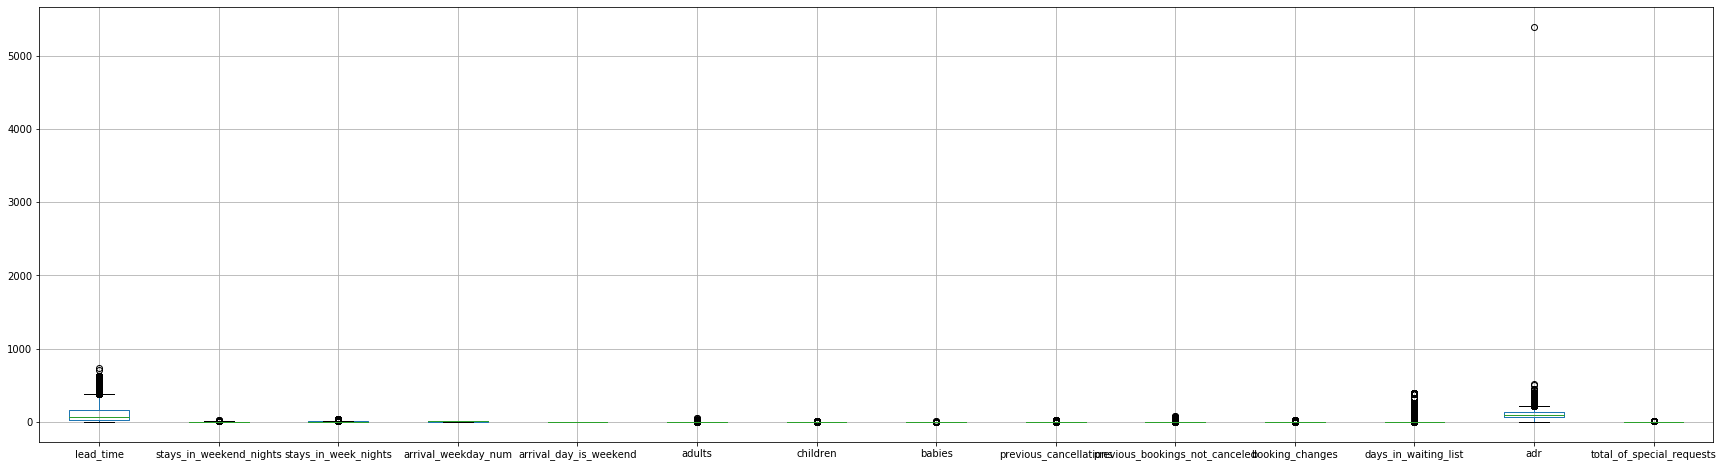

In [17]:
df_hotel = pd.read_pickle('hotel_bookings_6.pkl')

df_hotel_cont = df_hotel[['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights','arrival_weekday_num','arrival_day_is_weekend', 'adults', 'children', 'babies', 'previous_cancellations'
         , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'total_of_special_requests']]

df_hotel_cont.boxplot(figsize=(30, 8))

We notice that there is a single outlier value of __adr__ column within upper quantile, that must be removed to unskew the data.
Rest of the columns have values outside Q3, however, they are all contiguous, therefore, they do not need to be removed in our opionion.

In [18]:
df_hotel = pd.read_pickle('hotel_bookings_6.pkl')

print('Before: ', df_hotel.shape)

df_hotel = df_hotel[df_hotel["adr"] != df_hotel["adr"].max()]

print('After: ', df_hotel.shape)

df_hotel.to_pickle('hotel_bookings_7.pkl')

Before:  (116412, 31)
After:  (116411, 31)


<hr>

Analysis of __adr (Average Daily Rate)__ based on month.
It should reveal relationship between month of the year and adr flucatuation.

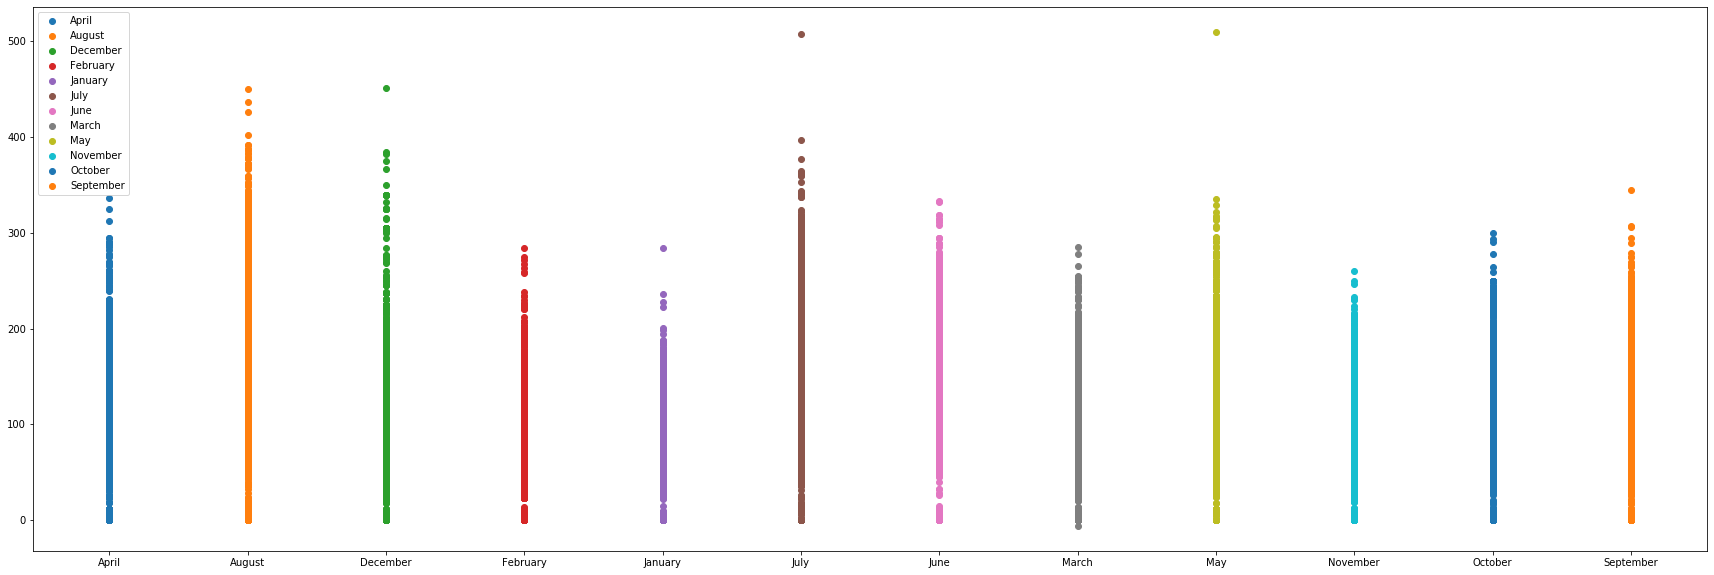

In [19]:
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

# Append month-number since that might 
import datetime
df_hotel['arrival_date_month_number'] = df_hotel['arrival_date_month'].apply(lambda x: datetime.datetime.strptime(x, "%B").month)


grps = df_hotel.groupby('arrival_date_month')
fig, ax = plt.subplots(figsize=(30,10))
ax.margins(0.05)
for name, group in grps:
    ax.plot(group.arrival_date_month, group.adr, marker='.', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

<hr>

Create correlation heatmap to find stronger correlation between various columns. It should indicate which features have strong positive or negative correlation with __adr__

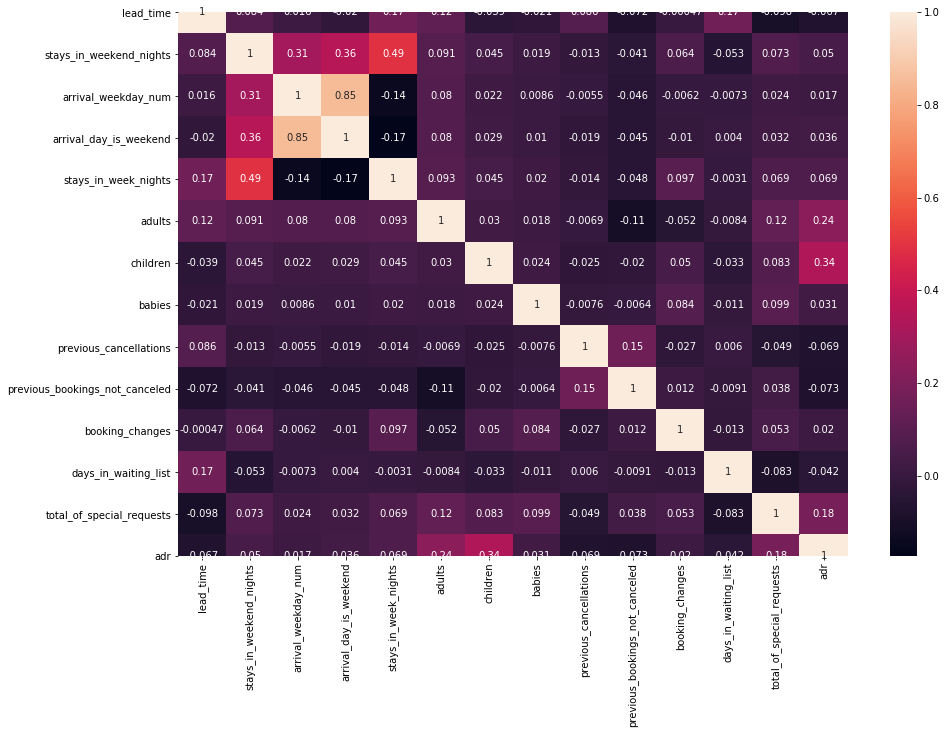

In [20]:
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

import seaborn as sns

df_hotel_cont = df_hotel[['lead_time', 'stays_in_weekend_nights','arrival_weekday_num','arrival_day_is_weekend', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations'
         , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'adr']]

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_hotel_cont.corr(), ax = ax, annot= True)

<hr>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1da524d0>,
      dtype=object)

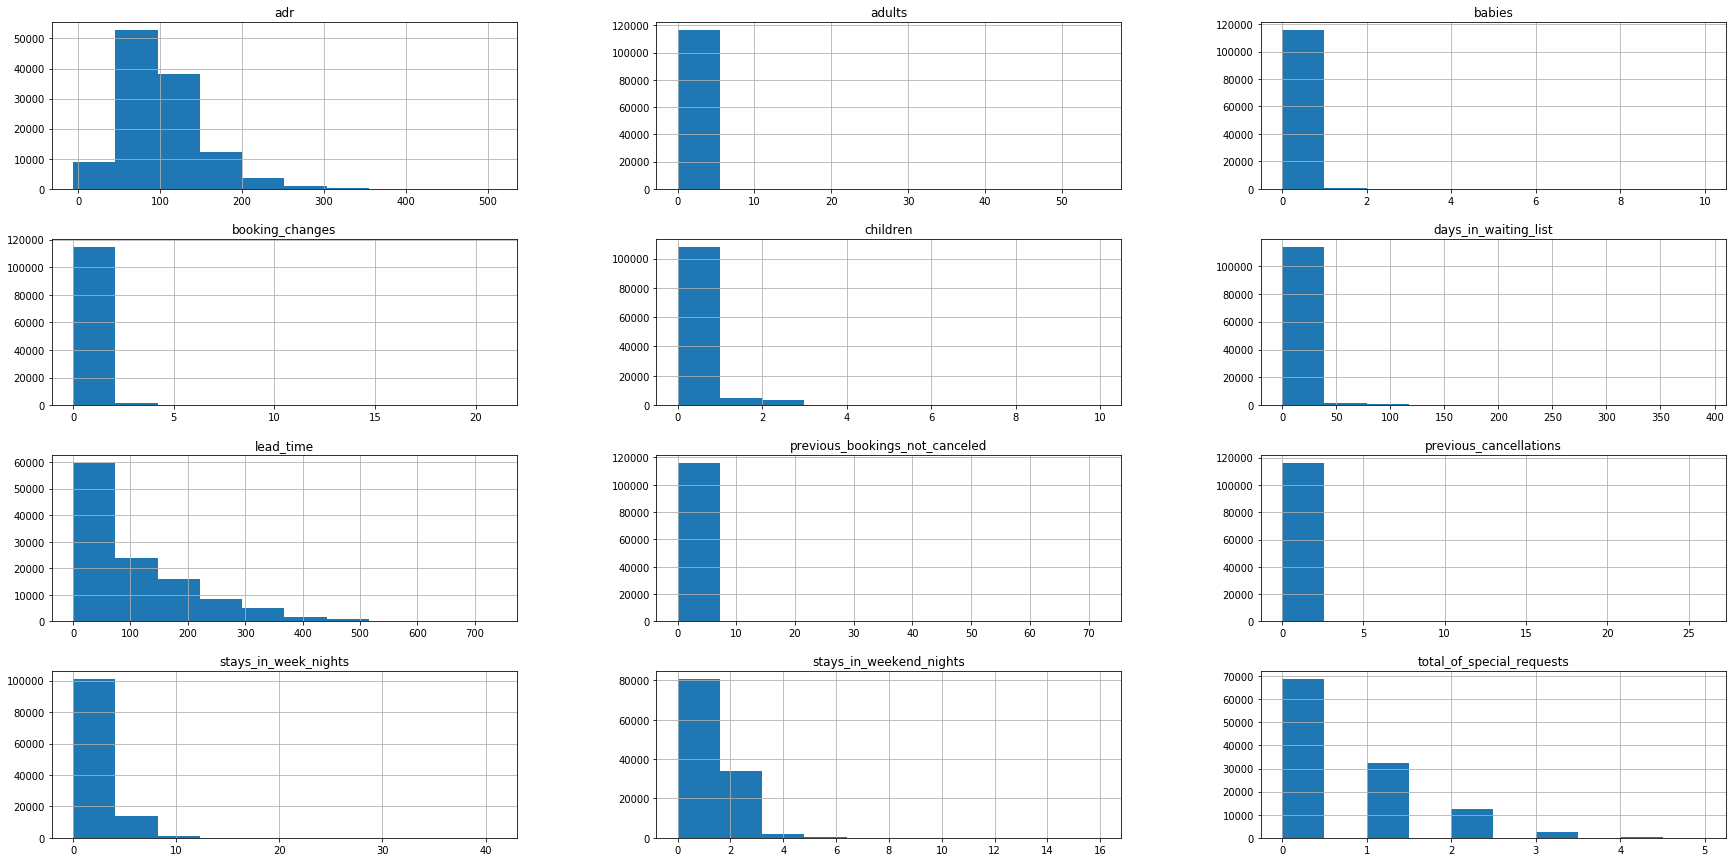

In [21]:
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

df_hotel_cont = df_hotel[['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations'
         , 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'adr']]

df_hotel_cont.hist(figsize = (30, 15))

<hr>

One-hot encode the following columns so that they can be plotted/used for regression analysis.

> - __hotel__
> - __country__
> - __market_segment__
> - __arrival_date_month__
> - __meal__
> - __deposit_type__
> - __total_of_special_requests__
> - __reservation_status__
> - __distribution_channel__
> - __reserved_room_type__
> - __assigned_room_type__
> - __customer_type__

In [ ]:
df_hotel = pd.read_pickle('hotel_bookings_7.pkl')

categorical_cols = ['hotel', 'country', 'market_segment', 'arrival_date_month','meal','deposit_type','total_of_special_requests','reservation_status',
                    'distribution_channel','reserved_room_type', 'assigned_room_type', 'customer_type']

df_hotel = pd.get_dummies(data=df_hotel, columns = categorical_cols)

df_hotel.get_dtype_counts()

df_hotel.to_pickle('hotel_bookings_8.pkl')

print(df_hotel.shape)
df_hotel.dtypes.value_counts()